In [1]:
import numpy as np
import scipy
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.image as img
from analysis_utils import basic_statistics, create_transition_matrix, calculate_expectations, analyze_state_repetition, analyze_markov_property

Let's take a look at the cell life history for `r-pentomino` run for 500 time steps.

Number of live cells at each time step:
 [  5   6   7   9   8   9  12  11  18  11  11  10  13  16  19  19  23  25
  35  25  32  27  37  30  46  39  45  30  31  29  27  32  32  39  34  29
  34  31  34  36  33  31  29  34  31  42  37  36  45  48  64  45  60  50
  67  58  66  68  72  72  79  75  80  67  69  73  65  56  61  52  53  60
  65  70  71  73  65  69  77  75  67  77  77  73  84  74  87  95  90  97
  98  92 103  93  97 100  95 114 108 121 121 124 125 123 132 138 150 163
 152 139 145 138 144 153 152 144 135 140 137 152 148 146 147 172 167 173
 161 168 164 163 178 174 174 179 162 188 167 177 161 176 182 174 167 180
 188 195 197 199 221 221 214 188 195 209 204 183 188 189 185 189 185 192
 179 186 173 174 184 206 181 184 165 164 155 168 140 149 141 160 162 140
 152 133 142 133 135 147 149 142 147 147 145 155 146 151 132 131 122 143
 119 137 120 130 119 117 115 125 118 131 114 119 111 128 110 118 102 108
 109 102 110 110 108 101 109 109 105 128 105 119 113 127 126 130 123 131
 136 149 1

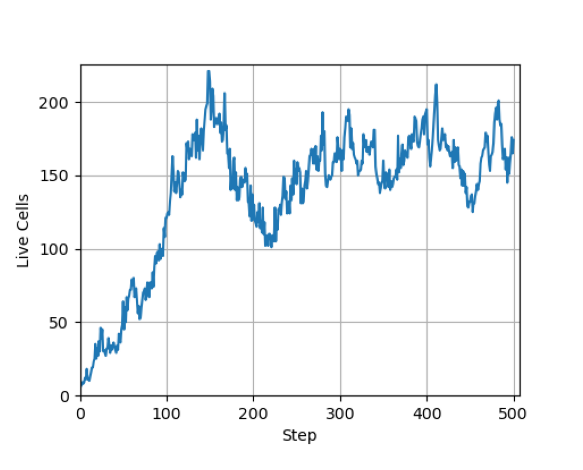

In [2]:
live_cells_time_series = np.loadtxt('simulation_data/r-pentomino/live_cell_history.txt', dtype=np.int64)
print("Number of live cells at each time step:\n",live_cells_time_series)
history = img.imread('images/r-pentomino.png')
plt.imshow(history)
plt.axis('off')
plt.tight_layout()
plt.show()

Let's first look at the basic statistics of the data:

In [3]:
stats = basic_statistics(live_cells_time_series)
print("Basic statistics:")
for key, value in stats.items():
    print(f'\t{key}:    {int(value)}')

Basic statistics:
	mean:    136
	variance:    2371
	std_dev:    48



That variance is huge!   
   
   
I'm assuming that the "process" we're looking at has the Markov property--that it's memoryless. Let's look at the transition matrix, where the states are the number of live cells.

In [4]:
tm_info = create_transition_matrix(live_cells_time_series)
tm = tm_info['transition_matrix']
for row in tm:
    for transition_probability in row:
        if abs(transition_probability - 0) < 1e-8 or abs(transition_probability - 1) < 1e-8:
            print(f'{int(transition_probability):^6}', end='')  # If the probability is 0 or 1, print it with no decimals
        else:
            print(f'{transition_probability:^6.3f}', end='')  # any other probability gets 3 decimal places
    print() # print a new line at the end of a distributiuon

  0     1     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0   
  0     0     1     0     0     0     0

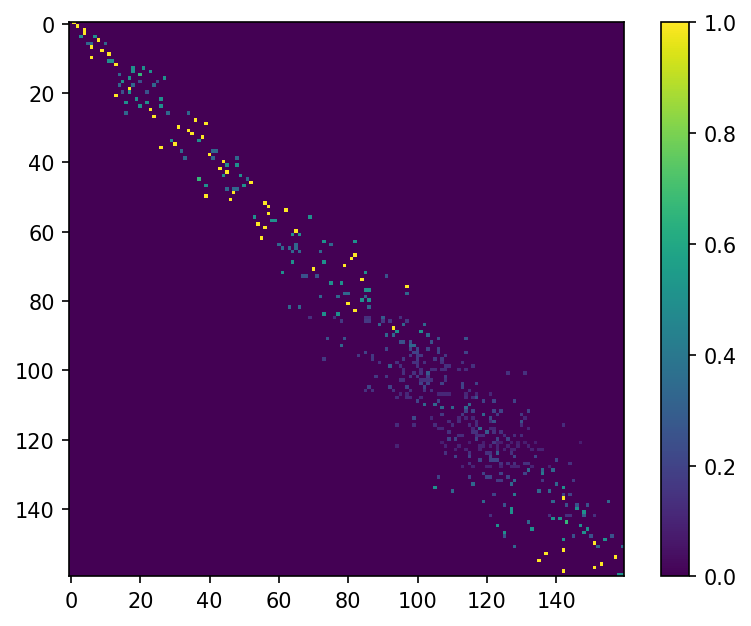

In [5]:
fig = plt.figure(dpi=150)
plt.imshow(tm)
plt.colorbar()
plt.show()
plt.close()

The transition matrix is incredibly sparse here, and given that the number of live cells never "latches" to a particular value, we can infer that there are no absorbing states. Let's check this:

In [6]:
absorbing_states = [state+1 for state in range(len(tm[0])) if tm[state][state]==1]
print("There are", len(absorbing_states), "absorbing states.")

There are 0 absorbing states.


We can also check how well the transition matrix represents the process by using it to calculate the conditional expectation for each time step:
$$ E[X_{t+1}|X_t=x] = \sum_y yP(X_{t+1}=y|X_t=x) $$
We get $P(X_{t+1}=y|X_t=x)$ from the rows of the transition matrix, where $x$ is the state/number of live cells. 

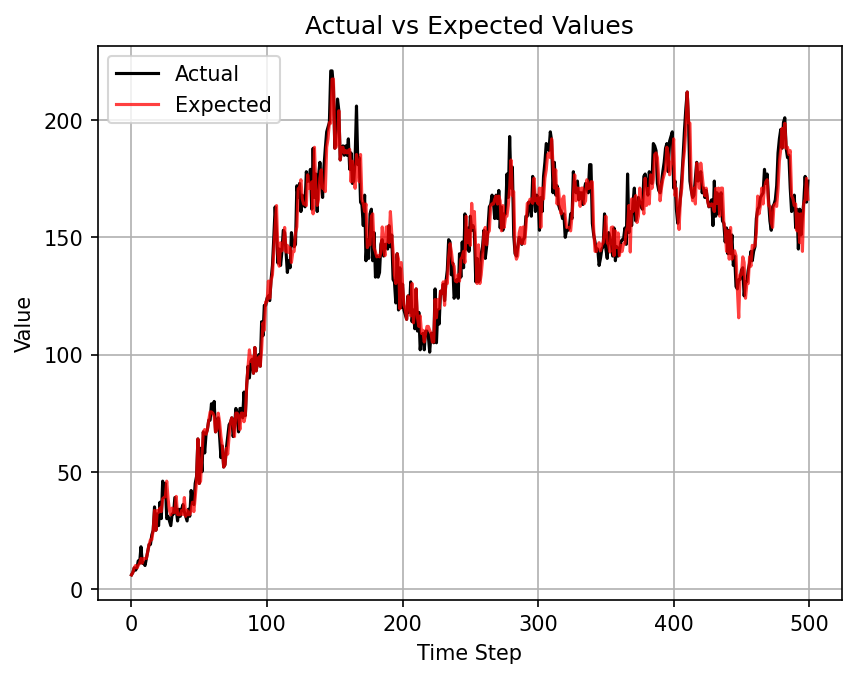

Root Mean Squared Error: 7.954519729498704


In [7]:
# Calculate expectations
expected_values = calculate_expectations(live_cells_time_series, tm_info)

plt.figure(dpi=150)
plt.plot(live_cells_time_series[1:], label='Actual', color='black')
plt.plot(expected_values, label='Expected', alpha=0.75, color='red')
plt.grid('on', which='both')
plt.title('Actual vs Expected Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate RMSE--how far the prediction deviates from the actual
mse = np.sqrt(np.mean((live_cells_time_series[1:] - expected_values)**2))
print(f"Root Mean Squared Error: {mse}")

An RMSE of 7.95 is not bad! The transition matrix clearly doesn't perfectly represent the the process, though that is what I expected; the count of live cells is an incomplete knowledge store for the Game of Life.

In [8]:
state_counts, transitions = analyze_state_repetition(live_cells_time_series)

Total time steps: 501
Unique states observed: 160
States that appear more than once: 104
States with multiple different next states: 104


In [9]:
print("Max number of live cells:", max(live_cells_time_series), "\nMin number of live cells:", min(live_cells_time_series))
not_in = (state for state in range(max(live_cells_time_series)+1) if state not in live_cells_time_series)
not_in = sorted(not_in)
print('There are', len(not_in), "states not present in our sample path. They are:")
print(not_in[:10])
print(not_in[10:19])
print(not_in[20:29])
print(not_in[30:39])
print(not_in[40:49])
print(not_in[50:59])
print(not_in[60:])

Max number of live cells: 221 
Min number of live cells: 5
There are 62 states not present in our sample path. They are:
[0, 1, 2, 3, 4, 14, 15, 17, 20, 21]
[22, 24, 26, 28, 38, 40, 41, 43, 44]
[49, 51, 54, 55, 57, 59, 62, 63, 76]
[81, 82, 83, 85, 86, 88, 89, 91, 94]
[99, 104, 106, 107, 112, 116, 194, 198, 200]
[203, 207, 208, 210, 211, 213, 215, 216, 217]
[219, 220]


In [10]:
print(float(len(not_in))/max(live_cells_time_series))

0.28054298642533937


There are ~28.1% of possible states (below the highest state observed) that are never reached by the process. Is it possible that they will appear if the process is allowed to run for longer? It's probably dependent on the physical configuration.

In [11]:
def print_markov_analysis(markov_analysis):
    for state in sorted(markov_analysis.keys()):
        info = markov_analysis[state]
        print(f"\nState {int(state)}:")
        print(f"  Entropy: {info['entropy']:.3f}")
        print(f"  Number of unique next states: {info['unique_next_states']}")
        print("  Transitions:")
        for next_state, count in info['transitions'].items():
            print(f"    -> {int(next_state)}: {count} times")

In [12]:
# print_markov_analysis(analyze_markov_property(transitions,state_counts))

This process, at least for this particular initial configuration, is clearly not simple to analyze--it's definitely not a simple random walk. It also doesn't perfectly satisfy the conditions of a Markov Chain, given that the RMSE derived from the transition matrix is nonzero. I expected the process to follow a hidden Markov model, given that we have an observable process that depends on a hidden state (and the assumption that there is some underlying Markov chain that we can't observe). 